In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import numpy as np

In [2]:
# Load data
version = 3 # just 3 is available
ds = tfds.load(f'speech_commands:0.0.{version}')
train = ds['train']
val = ds['validation']

2024-07-05 17:54:52.717720: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-07-05 17:54:52.717749: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-07-05 17:54:52.717754: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-07-05 17:54:52.717772: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-05 17:54:52.717784: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
#visual class names
info = tfds.builder(f'speech_commands:0.0.{version}').info
class_names = info.features['label'].names
for i,c in enumerate(class_names):
    print(f'{i}: {c}')
    

0: down
1: go
2: left
3: no
4: off
5: on
6: right
7: stop
8: up
9: yes
10: _silence_
11: _unknown_


In [4]:
# custom MFCC function
# An integer representing the sampling rate.
sr = 16000
# An integer scalar Tensor. The window length in samples.
frame_length = int(sr/40) #25 ms
# An integer scalar Tensor. The number of samples to step.
frame_step = int(sr/100) #10 ms
# An integer scalar Tensor. The size of the FFT to apply.
fft_length = int(sr/40) #25 ms
# An integer representing the num of filterbanks.
num_feats = 40

def get_mfccs(
        audio,
        channels= 1,
        sample_rate= 16000,
        frame_length= 400,
        frame_step = 160,
        fft_length = 400,
        num_feats = 40
    ):
    audio = tf.cast(audio, tf.float32)
    audio = audio[:16000]
    zero_padding = tf.zeros([16000] - tf.shape(audio), dtype=tf.float32)
    audio = tf.concat([audio, zero_padding], 0)
    stfts = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)

    spectrograms = tf.abs(stfts)

    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 0 , sample_rate/2, num_feats
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz, upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
      spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
      log_mel_spectrograms)
    mfccs = mfccs[..., tf.newaxis]

    return mfccs


In [5]:
# Preprocessing function
def preprocess_data(example):
    audio = example['audio']
    label = example['label']
    # label = tf.one_hot(label, 12)
    mfccs = get_mfccs(audio)
    return mfccs, label

In [6]:
# Create dataset
train_samples = train
train_data = train_samples.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [7]:
#batch
batch_size = 32
train_data_batched = train_data.batch(batch_size)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

def residual_block(inputs, filters, kernel_size=(3, 3), strides=(1, 1)):
    """A basic residual block for BC-ResNet."""
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    if strides != (1, 1) or inputs.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same')(inputs)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = inputs
    
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_bc_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolutional layer
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    x = residual_block(x, 128, strides=(2, 2))
    x = residual_block(x, 128)
    
    x = residual_block(x, 256, strides=(2, 2))
    x = residual_block(x, 256)
    
    x = residual_block(x, 512, strides=(2, 2))
    x = residual_block(x, 512)
    
    # Global average pooling and output layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model




In [9]:
# Example usage
input_shape = (98, 40, 1)  # Shape of the MFCC input
num_classes = 12  # Number of output classes
model = build_bc_resnet(input_shape, num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 98, 40, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 49, 20,    │      3,200 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 49, 20,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 49, 20,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 25, 10,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 25, 10,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 10,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 25, 10,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 25, 10,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 10,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 25, 10,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 25, 10,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 25, 10,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 10,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 25, 10,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 25, 10,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 10,    │        256 │ conv2d_4[0][0]  

 Total params: 11,453,452 (43.69 MB)

 Trainable params: 11,443,852 (43.65 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [44]:
# plot the model

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
#preprocess validation data
val_samples = val.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_samples_batched = val_samples.batch(32)

In [12]:
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# Define TensorBoard callback
log_dir = "logs/fit/"  # Define your log directory
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Define ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='res_net/best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.weights.h5',
    monitor='val_accuracy',
    save_best_only=False,
    save_weights_only=True,
    mode='max',
    verbose=1
)

In [13]:
# Train the model
history = model.fit(
    train_data_batched,
    epochs=10,
    validation_data=val_samples_batched,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/10


2024-07-05 17:54:54.957194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2673/2673 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6844 - loss: 1.1612
Epoch 1: val_accuracy improved from -inf to 0.71619, saving model to res_net/best_model_epoch_01_val_acc_0.72.weights.h5
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 387s 142ms/step - accuracy: 0.6844 - loss: 1.1611 - val_accuracy: 0.7162 - val_loss: 0.8376
Epoch 2/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8779 - loss: 0.3946
Epoch 2: val_accuracy improved from 0.71619 to 0.90418, saving model to res_net/best_model_epoch_02_val_acc_0.90.weights.h5
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 372s 139ms/step - accuracy: 0.8779 - loss: 0.3946 - val_accuracy: 0.9042 - val_loss: 0.2951
Epoch 3/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9205 - loss: 0.2634
Epoch 3: val_accuracy improved from 0.90418 to 0.92932, saving model to res_net/best_model_epoch_03_val_acc_0.93.weights.h5
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 379s 142ms/step - accuracy: 0.9205 - loss: 0.2634 - val_accuracy: 0.9293 - val_loss: 0.2326
Epo

In [18]:
# Save the model
model.save("audio_classifier_MFCC_res_net.keras")

In [19]:
# Load the model
model = tf.keras.models.load_model("audio_classifier_MFCC_res_net.keras")

In [16]:
# Test the model
test = ds['test']
test_samples = test
test_data = test_samples.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_data_batched = test_data.batch(32)
test_loss, test_acc = model.evaluate(test_data_batched)
print('test_acc:', test_acc, 'test_loss', test_loss)


153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9088 - loss: 0.3660
test_acc: 0.9122699499130249 test_loss 0.382233202457428


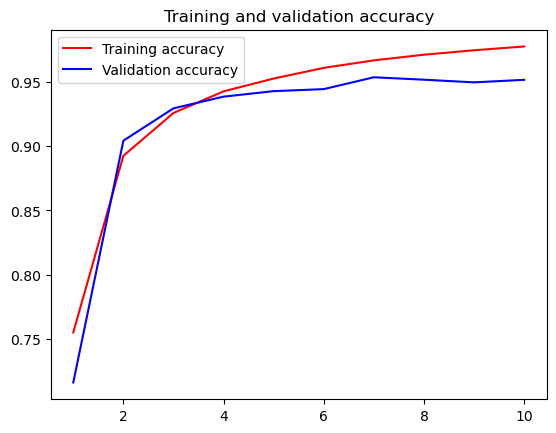

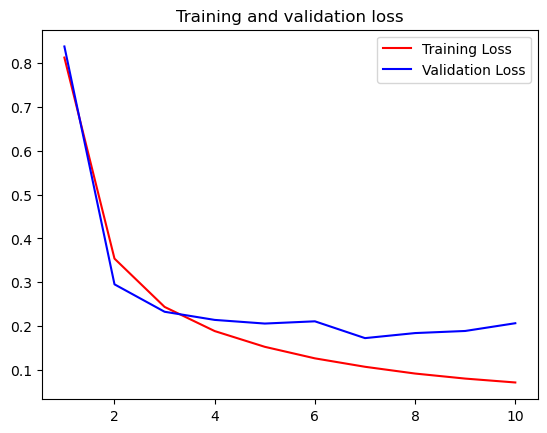

In [24]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.clf()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [20]:
# load each weights to evaluate on test set
import os

weights_dir = 'res_net'
weights_files = os.listdir(weights_dir)
weights_files = [f for f in weights_files if f.endswith('.h5')]
weights_files.sort()

test_accs = []
test_losses = []

for weights in weights_files:
    model.load_weights(os.path.join(weights_dir, weights))
    test_loss, test_acc = model.evaluate(test_data_batched)
    test_accs.append(test_acc)
    test_losses.append(test_loss)
    print(f'{weights} test_acc: {test_acc}, test_loss: {test_loss}')
 

153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6376 - loss: 1.0992
best_model_epoch_01_val_acc_0.72.weights.h5 test_acc: 0.6408997774124146, test_loss: 1.0909380912780762
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8719 - loss: 0.3894
best_model_epoch_02_val_acc_0.90.weights.h5 test_acc: 0.8756646513938904, test_loss: 0.390205055475235
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8393 - loss: 0.5020
best_model_epoch_03_val_acc_0.93.weights.h5 test_acc: 0.8415132761001587, test_loss: 0.5013409852981567
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8775 - loss: 0.3990
best_model_epoch_04_val_acc_0.94.weights.h5 test_acc: 0.8846625685691833, test_loss: 0.3909507989883423
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8899 - loss: 0.3806
best_model_epoch_05_val_acc_0.94.weights.h5 test_acc: 0.893047034740448, test_loss: 0.37104278802871704
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9076 - loss: 0.3039
best_model_epoch_06_val_a

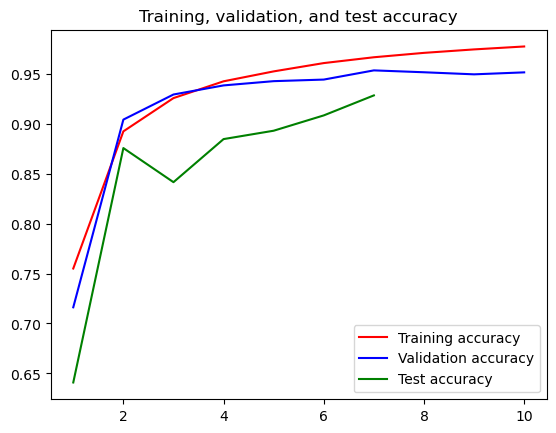

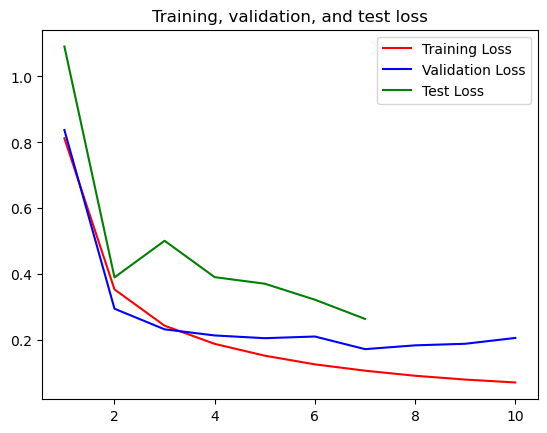

In [46]:
# Plot test accuracy and loss with train and validation accuracy and loss
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.plot(epochs[:7],test_accs, 'g', label='Test accuracy')
plt.title('Training, validation, and test accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.plot(epochs[:7],test_losses, 'g', label='Test Loss')
plt.title('Training, validation, and test loss')
plt.legend()
plt.show()